In [91]:
import cv2
import numpy as np
import mss
import base64
from io import BytesIO
from PIL import Image
import os
import time
import pytesseract
import pydirectinput
from gymnasium import Env  # Изменено на gymnasium
from gymnasium.spaces import Box, Discrete
from selenium.webdriver.common.alert import Alert
from selenium import webdriver
from matplotlib import pyplot as plt
from selenium.webdriver.common.by import By
from stable_baselines3 import DQN
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from stable_baselines3.common.callbacks import BaseCallback

import pyautogui

In [92]:
images_folder = 'images'

def find_object_on_screen(image_path, screenshot_path=None, threshold=0.8):
    """
    Найти объект на экране по переданному изображению объекта.
    
    :param image_path: Путь к изображению объекта, который нужно найти.
    :param screenshot_path: Путь к скриншоту экрана. Если None, будет сделан новый скриншот.
    :param threshold: Пороговое значение для сопоставления (по умолчанию 0.8).
    :return: Координаты верхнего левого и нижнего правого углов объекта (или None, если объект не найден).
    """
    # Сделать скриншот экрана, если его путь не передан
    if screenshot_path is None:
        screen = pyautogui.screenshot()
        screen = np.array(screen)
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    else:
        screen = cv2.imread(screenshot_path, cv2.IMREAD_GRAYSCALE)

    object_image_path = f'./{images_folder}/{image_path}.png'
    
    # Загрузить изображение объекта
    object_image = cv2.imread(object_image_path, cv2.IMREAD_GRAYSCALE)
    h, w = object_image.shape

    # Сопоставление шаблонов
    result = cv2.matchTemplate(screen, object_image, cv2.TM_CCOEFF_NORMED)
    loc = np.where(result >= threshold)

    # Вернуть координаты
    for pt in zip(*loc[::-1]):
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)
        return top_left, bottom_right
    
    # Если объект не найден
    return None

In [93]:
def click_button(button_name):
    coordinates = find_object_on_screen(image_path=button_name)
    if coordinates:
        top_left, bottom_right = coordinates
        button_centre = ((top_left[0] + bottom_right[0]) / 2, (top_left[1] + bottom_right[1]) / 2)
        
        # debug issue
        # print("Top left corner:", top_left)
        # print("Bottom right corner:", bottom_right)
        # print("Bottom centre:", button_centre)
        
        pydirectinput.click(x=int(button_centre[0]), y=int(button_centre[1]))
    # else:
    #     print(f"Button {button_name} not found.")

In [106]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
    
        # Настройки observation_space и action_space
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 100), dtype=np.uint8)
        self.action_space = Discrete(3)
    
        # Настройки ChromeDriver
        chrome_driver_path = r"D:\Users\Legion\Programs\ChromeDriver\chromedriver.exe"
        service = Service(chrome_driver_path)
        chrome_options = Options()
        chrome_options.add_argument("--disable-gpu")
    
        # Инициализация ChromeDriver
        self.driver = webdriver.Chrome(service=service, options=chrome_options)
        self.driver.get("https://dino.zone/ru/")

        # Ожидание загрузки страницы и появления окна
        time.sleep(2)
    
        # Нажать кнопку "deny"
        self.click_button('deny')
    
        # Инициализация mss для захвата экрана
        self.cap = mss.mss()
    
        # Поиск области игры на экране
        game_area_coordinates = self.find_object_on_screen('game_area')
        if game_area_coordinates:
            top_left, bottom_right = game_area_coordinates
            width = max(1, bottom_right[0] - top_left[0])  # Ensure positive width
            height = max(1, bottom_right[1] - top_left[1])  # Ensure positive height
    
            print(f"top: {top_left[1]}, left: {top_left[0]}, width: {width}, height: {height}")
            self.game_location = {
                "top": int(top_left[1]),
                "left": int(top_left[0]),
                "width": int(width),
                "height": int(height)
            }
    
            try:
                # Захват экрана и конвертация в изображение
                screenshot = self.cap.grab(self.game_location)  # Используем self.cap для захвата
                img = np.array(screenshot)
                print("Screenshot successful!")
                plt.imshow(img)
                plt.show()  # Показываем изображение
            except Exception as e:
                print(f"Error grabbing screenshot: {e}")
    
        self.done_location = {'top': 0, 'left': 0, 'width': 500, 'height': 500}

    def step(self, action):
        action_map = {
            0: Keys.ARROW_UP,  # Jump
            1: Keys.ARROW_DOWN,  # Duck
            2: None  # No action
        }

        # Execute the action in the game
        if action_map[action]:
            self.driver.find_element(By.TAG_NAME, "body").send_keys(action_map[action])
            time.sleep(0.1)  # Small delay to simulate human-like input

        # Get the new game state
        done, done_cap = self.get_done()
        new_observation = self.get_observation()

        # Calculate reward based on the game's state
        reward = -1 if done else 1  # Negative reward for losing, positive for staying alive

        info = {}
        truncated = False

        return new_observation, reward, done, truncated, info

    def reset(self, seed=None, options=None):
        # Reset the environment (refresh the driver, restart the game)
        self.driver.refresh()
        time.sleep(1)
        self.click_button('restart')

        # Return the observation and reset information
        observation = self.get_observation()  # Resized observation
        reset_info = {}  # Or None, if not needed
        return observation, reset_info

    def close(self):
        self.driver.quit()
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100, 84))  # Resize to match observation space
        # Add channels first
        channel = np.reshape(resized, (1, 84, 100))

        return channel

    def get_done(self):
        screenshot_base64 = self.driver.get_screenshot_as_base64()
        screenshot_bytes = base64.b64decode(screenshot_base64)
        screenshot_image = Image.open(BytesIO(screenshot_bytes))
        screenshot_np = np.array(screenshot_image)[:, :, :3]

        done_cap = screenshot_np[
            self.done_location['top']:self.done_location['top'] + self.done_location['height'],
            self.done_location['left']:self.done_location['left'] + self.done_location['width']
        ]

        done_cap_gray = cv2.cvtColor(done_cap, cv2.COLOR_RGB2GRAY)
        _, done_cap_thresh = cv2.threshold(done_cap_gray, 128, 255, cv2.THRESH_BINARY)

        done = self.find_object_on_screen('restart')  # Check for the restart button

        return done, done_cap
    
    def find_object_on_screen(self, image_path, screenshot_path=None, threshold=0.8):
        """
        Найти объект на экране по переданному изображению объекта.
        
        :param image_path: Путь к изображению объекта, который нужно найти.
        :param screenshot_path: Путь к скриншоту экрана. Если None, будет сделан новый скриншот.
        :param threshold: Пороговое значение для сопоставления (по умолчанию 0.8).
        :return: Координаты верхнего левого и нижнего правого углов объекта (или None, если объект не найден).
        """
        # Сделать скриншот экрана, если его путь не передан
        if screenshot_path is None:
            screen = pyautogui.screenshot()
            screen = np.array(screen)
            screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        else:
            screen = cv2.imread(screenshot_path, cv2.IMREAD_GRAYSCALE)
    
        object_image_path = f'./{images_folder}/{image_path}.png'
        
        # Загрузить изображение объекта
        object_image = cv2.imread(object_image_path, cv2.IMREAD_GRAYSCALE)
        h, w = object_image.shape
    
        # Сопоставление шаблонов
        result = cv2.matchTemplate(screen, object_image, cv2.TM_CCOEFF_NORMED)
        loc = np.where(result >= threshold)
    
        # Вернуть координаты
        for pt in zip(*loc[::-1]):
            top_left = pt
            bottom_right = (pt[0] + w, pt[1] + h)
            return top_left, bottom_right
        
        # Если объект не найден
        return None
    
    def click_button(self, button_name):
        coordinates = self.find_object_on_screen(image_path=button_name)
        if coordinates:
            top_left, bottom_right = coordinates
            button_centre = ((top_left[0] + bottom_right[0]) / 2, (top_left[1] + bottom_right[1]) / 2)
            
            # debug issue
            # print("Top left corner:", top_left)
            # print("Bottom right corner:", bottom_right)
            # print("Bottom centre:", button_centre)
            
            pydirectinput.click(x=int(button_centre[0]), y=int(button_centre[1]))
        # else:
        #     print(f"Button {button_name} not found.")


In [107]:
# Define a custom callback to save model checkpoints and track performance
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, save_path, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.save_path = save_path
        self.best_mean_reward = -float('inf')

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:
            mean_reward = self.training_env.get_attr("reward")
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                self.model.save(self.save_path)
                print(f"Saving new best model with reward: {self.best_mean_reward}")
        return True

top: 421, left: 53, width: 254, height: 144
Screenshot successful!


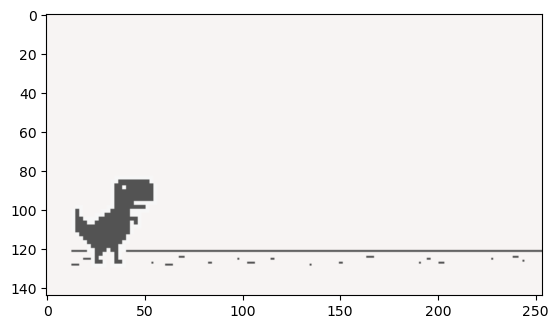

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [108]:
# Create the environment (ensure WebGame is defined with get_observation() updated)
env = WebGame()

# Ensure the tensorboard log directory exists
tensorboard_log_dir = "dqn_tensorboard/"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Initialize the model
model = DQN(
    'CnnPolicy', env, verbose=1, buffer_size=50000, batch_size=16,
    learning_starts=1000, optimize_memory_usage=False, tensorboard_log=tensorboard_log_dir
)

# Define the path to save the model
model_save_path = "best_model_dqn"

# Create the callback instance
callback = SaveOnBestTrainingRewardCallback(save_path=model_save_path)

In [109]:
# Train the model
model.learn(model.learn(total_timesteps=10000, callback=callback, reset_num_timesteps=False))

# Save the trained model
model.save("final_model_dqn")

Logging to ./dqn_tensorboard/DQN_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.5     |
|    ep_rew_mean      | 19.5     |
|    exploration_rate | 0.918    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 45       |
|    total_timesteps  | 86       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.2     |
|    ep_rew_mean      | 20.2     |
|    exploration_rate | 0.831    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 84       |
|    total_timesteps  | 178      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.1     |
|    ep_rew_mean      | 21.1     |
|    exploration_rate | 0.737    |
| time/             

WebDriverException: Message: unknown error: unhandled inspector error: {"code":-32000,"message":"Not attached to an active page"}
  (Session info: chrome=130.0.6723.117)
Stacktrace:
	GetHandleVerifier [0x00007FF7286738A5+3004357]
	(No symbol) [0x00007FF728309970]
	(No symbol) [0x00007FF7281B582A]
	(No symbol) [0x00007FF7281A2FB4]
	(No symbol) [0x00007FF7281A15CD]
	(No symbol) [0x00007FF7281A1FEF]
	(No symbol) [0x00007FF7281C3E10]
	(No symbol) [0x00007FF72825AE69]
	(No symbol) [0x00007FF72822BBDA]
	(No symbol) [0x00007FF72824BA4C]
	(No symbol) [0x00007FF72822B983]
	(No symbol) [0x00007FF7281F7628]
	(No symbol) [0x00007FF7281F8791]
	GetHandleVerifier [0x00007FF72869A00D+3161901]
	GetHandleVerifier [0x00007FF7286EE060+3506048]
	GetHandleVerifier [0x00007FF7286E400D+3465005]
	GetHandleVerifier [0x00007FF728460EEB+830987]
	(No symbol) [0x00007FF72831467F]
	(No symbol) [0x00007FF7283109D4]
	(No symbol) [0x00007FF728310B6D]
	(No symbol) [0x00007FF728300149]
	BaseThreadInitThunk [0x00007FFF4DF0257D+29]
	RtlUserThreadStart [0x00007FFF4FDCAF08+40]


In [72]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

Button restart not found.
Button restart not found.
Button restart not found.


In [73]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
        return True

In [81]:
CHECKPOINT_DIR = 'train/'
LOG_DIR = 'logs/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Initialize the logging callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

model = DQN(
    'CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
    buffer_size=100000, batch_size=32, learning_starts=1000, optimize_memory_usage=False
)

# Train the model with logging callback
# model.learn(total_timesteps=100000, callback=callback)

model.load(os.path.join(CHECKPOINT_DIR, 'best_model_88000'))

for episode in range(5):
    obs, _ = env.reset()  # For VecEnv, or just obs = env.reset() for Gym
    total_reward = 0
    done = False
    
    while not done:
        action, _ = model.predict(obs)  # Get action from model
        
        result = env.step(int(action))  # Step in the environment and check result
        
        # Now adjust the unpacking based on the result
        obs, reward, done, another_flag, info = env.step(int(action))
        total_reward += reward
        time.sleep(0.01)
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total Reward for episode 0 is 28
Total Reward for episode 1 is 28
Total Reward for episode 2 is 28
Total Reward for episode 3 is 28


KeyboardInterrupt: 